In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import zipfile
from keras import regularizers

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
local_zip = "/content/drive/MyDrive/creditcard.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/credit_card")
zip_ref.close()

In [85]:
df = pd.read_csv("/credit_card/creditcard.csv")

**Balancing the data**

In [86]:
non_fraud=df[df["Class"]==0]
fraud = df[df["Class"]==1]
non_fraud.shape, fraud.shape

((284315, 31), (492, 31))

In [87]:
non_fraud=non_fraud.sample(fraud.shape[0])
non_fraud.shape

(492, 31)

In [88]:
data = fraud.append(non_fraud, ignore_index=True)
data.shape
data["Class"].value_counts()

1    492
0    492
Name: Class, dtype: int64

In [89]:
x_data= data.drop(columns=["Class", "Time"], axis=0)
label = data["Class"]

**Splitting Training and Test data**

In [134]:
x_data = data.sample(frac=1) # Shuffling the data
train_data_full= x_data.iloc[:689,:]
test_data_full = x_data.iloc[689:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1]

In [135]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(689, 30)
(295, 30)
(689,)
(295,)


**Normalizing the data**

In [137]:
mean = train_data.mean(axis=0)
train_data -=mean
std =train_data.std(axis=0)
train_data /=std

test_data -=mean
test_data /=std

In [138]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

**Building The Network**

In [140]:
def build_model():
  model= models.Sequential()
  model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu"))
  model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu"))
  model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu"))
  model.add(layers.Dense(1,activation="sigmoid"))
  model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
  return model

**K Fold Validation**

In [141]:
k= 5
num_val_sample = len(train_data) // k
num_epochs = 40
all_scores = []
all_val_loss_histories = []
all_val_acc_histories = []
all_loss_histories =[]
all_acc_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, verbose=1)
  val_loss, val_acc = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_acc_history = history.history["val_accuracy"]
  loss_history = history.history["loss"]
  acc_history = history.history["accuracy"]
  all_loss_histories.append(loss_history)
  all_acc_histories.append(acc_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_acc_histories.append(val_acc_history)
  all_scores.append(val_acc)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_acc_hist = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
ave_acc_hist = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
print("All Accuracy values evaluated by teh Model are given below:")
all_scores

processing fold # 0
Epoch 1/40
18/18 [==============================] - 1s 18ms/step - loss: 0.8760 - accuracy: 0.5340 - val_loss: 0.8407 - val_accuracy: 0.6642
Epoch 2/40
18/18 [==============================] - 0s 4ms/step - loss: 0.8216 - accuracy: 0.7311 - val_loss: 0.8000 - val_accuracy: 0.8029
Epoch 3/40
18/18 [==============================] - 0s 5ms/step - loss: 0.7923 - accuracy: 0.8081 - val_loss: 0.7608 - val_accuracy: 0.8540
Epoch 4/40
18/18 [==============================] - 0s 4ms/step - loss: 0.7745 - accuracy: 0.8152 - val_loss: 0.7218 - val_accuracy: 0.8759
Epoch 5/40
18/18 [==============================] - 0s 4ms/step - loss: 0.7111 - accuracy: 0.8604 - val_loss: 0.6794 - val_accuracy: 0.8905
Epoch 6/40
18/18 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.8534 - val_loss: 0.6344 - val_accuracy: 0.9051
Epoch 7/40
18/18 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.8715 - val_loss: 0.5819 - val_accuracy: 0.9051

[0.9355932474136353,
 0.9254237413406372,
 0.9389830231666565,
 0.9491525292396545,
 0.9322034120559692]

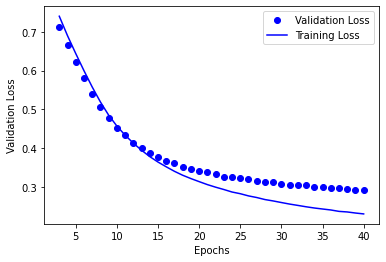

In [142]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_val_loss_hist[2:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_loss_hist[2:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

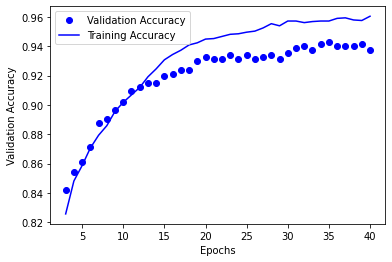

In [143]:
plt.plot(range(1, len(ave_val_acc_hist)+1)[2:], ave_val_acc_hist[2:], "bo", label="Validation Accuracy")
plt.plot(range(1, len(ave_val_acc_hist)+1)[2:], ave_acc_hist[2:], "b", label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

**Rebuilding the best fit Model**

In [147]:
from keras import regularizers
model= models.Sequential()
model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu", input_shape=(train_data.shape[1],)))

model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu"))

model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu"))

model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.002), activation="relu"))

model.add(layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

**Training the model with all samples**

In [148]:
model.fit(train_data, train_labels, epochs=40)

Epoch 1/40
22/22 [==============================] - 1s 2ms/step - loss: 0.9895 - accuracy: 0.1976
Epoch 2/40
22/22 [==============================] - 0s 2ms/step - loss: 0.8765 - accuracy: 0.4861
Epoch 3/40
22/22 [==============================] - 0s 2ms/step - loss: 0.7847 - accuracy: 0.7459
Epoch 4/40
22/22 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.7993
Epoch 5/40
22/22 [==============================] - 0s 2ms/step - loss: 0.6037 - accuracy: 0.8648
Epoch 6/40
22/22 [==============================] - 0s 2ms/step - loss: 0.5417 - accuracy: 0.8773
Epoch 7/40
22/22 [==============================] - 0s 2ms/step - loss: 0.4679 - accuracy: 0.9000
Epoch 8/40
22/22 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.9333
Epoch 9/40
22/22 [==============================] - 0s 2ms/step - loss: 0.3957 - accuracy: 0.9406
Epoch 10/40
22/22 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.9229
Epoch 11/40
22/22 [

**Evaluating the Network**

In [149]:
test_loss_score, test_acc_score=model.evaluate(test_data, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.2718 - accuracy: 0.9525


In [150]:
test_acc_score *100

95.25423645973206

**Predicting the values**

In [151]:
prediction=model.predict(test_data)
pred_norm =np.where(prediction>.5, 1, 0)
pred_norm[10:20].T

array([[1, 0, 0, 1, 1, 0, 0, 0, 0, 0]])

In [152]:
test_labels[10:20].astype(dtype="int")

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [153]:
pred_check =pred_norm[:].T.astype(dtype="int")

In [154]:
c = pred_check.size

In [155]:
comapre_pred_test = test_labels == pred_check

In [156]:
a = comapre_pred_test[comapre_pred_test[:]== False].size

In [157]:
b = comapre_pred_test[comapre_pred_test[:]==True].size

In [158]:
print("Incorrect Predictions are:", a, "and Correct predictions are :", b, " the percentage is:", round((b/c)*100,2), "%"  )

Incorrect Predictions are: 14 and Correct predictions are : 281  the percentage is: 95.25 %
